# Taux-SSH_feedback: 

coupling between Taux anomalies in the western equatorial Pacific and SSH anomalies in the eastern equatorial Pacific. Computes sea surface height anomalies (SSHA; used as a proxy for subsurface temperature) in the eastern equatorial Pacific (horizontal Niño3 average) regressed onto zonal wind stress anomalies (TauxA) in the western equatorial Pacific (horizontal Niño4 average).

#### Reference observations:
TropFlux and AVISO 1993-2018 (main)

SSH: JPL-MEASURES 1993-2021, CSIRO-SSH 1993-2019, GODAS 1980-2023, ORAS5 1958-2022, SODA3.4.2 1979-2018
Taux: ERA5 1940-2022, 20CRv3 1836-2015, NCEP2 1979-2023


In [2]:
from esmvalcore.dataset import Dataset

from esmvalcore.config import CFG
CFG['rootpath']['OBS6'].append(r'/g/data/kj13/datasets/esmvaltool/obsdata-v2') #NCEP-DOE-R2 tos

In [30]:
model_ssh_datasets = { 
"ACCESS-ESM1-5": 
    Dataset(
    short_name='zos',
    project='CMIP6',
    mip="Omon",
    exp="historical",
    ensemble="r1i1p1f1",
    # timerange="19790101/20190101",
    dataset="ACCESS-ESM1-5",
    grid="gn"
)}

#tauu
model_tauu = {"ACCESS-ESM1-5": 
    model_ssh_datasets["ACCESS-ESM1-5"].copy(short_name='tauu',mip="Amon")}
model_tauu["ACCESS-ESM1-5"].add_supplementary(short_name='areacella', mip='fx')

model_ssh_datasets["ACCESS-ESM1-5"].add_supplementary(short_name='areacello', mip='Ofx')

## obs zos required
obs_zos_datasets = {
"CMEMS": 
    Dataset(
    short_name='zos',
    dataset='CMEMS',
    mip="Omon",
    project='OBS6',
    type='sat',
    timerange="19930101/20190101",
    tier=2),

}
obs_tauu_datasets = {
 "ERA-Interim": 
     Dataset(
     short_name='tauu',
     dataset='ERA-Interim',
     mip="Amon",
     project='OBS6',
     type='reanaly',
     timerange="19930101/20190101",
     tier=3)
}

In [31]:
model_ssh_datasets = {name: dataset.load() for name, dataset in model_ssh_datasets.items()}
model_tauu = {name: dataset.load() for name, dataset in model_tauu.items()}

obs_zos_datasets = {name: dataset.load() for name, dataset in obs_zos_datasets.items()}
obs_tauu_datasets = {name: dataset.load() for name, dataset in obs_tauu_datasets.items()}

 tauu: attribute positive not present
loaded from file /g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r1i1p1f1/Amon/tauu/gn/v20191115/tauu_Amon_ACCESS-ESM1-5_historical_r1i1p1f1_gn_185001-201412.nc
 tauu: attribute positive not present
loaded from file 


In [15]:
from esmvalcore.preprocessor import anomalies
from esmvalcore.preprocessor import area_statistics
from esmvalcore.preprocessor import seasonal_statistics
from esmvalcore.preprocessor import rolling_window_statistics
from esmvalcore.preprocessor import convert_units
from esmvalcore.preprocessor import extract_region
from esmvalcore.preprocessor import extract_season
from esmvalcore.preprocessor import extract_month
from esmvalcore.preprocessor import detrend
from esmvalcore.preprocessor import regrid
from esmvalcore.preprocessor import detrend
from esmvalcore.preprocessor import mask_landsea
from esmvalcore.preprocessor import extract_time
import iris

import matplotlib.pyplot as plt
import iris.quickplot as qplt
import numpy as np
import scipy.stats

In [16]:
def ssh_east(cube):
    nino3_region = {"start_longitude": 210., "end_longitude": 270., "start_latitude": -5., "end_latitude": 5.}
    # cube = extract_time(cube, start_year=1979, end_year=2000, start_month=1, end_month=12, start_day=1, end_day=31)
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = convert_units(cube, units="cm")
    cube = mask_landsea(cube, mask_out="land") #irregular
    cube = anomalies(cube, period="full")
    cube = detrend(cube, dimension="time", method="linear")
    cube = extract_region(cube, **nino3_region)
    cube = area_statistics(cube,operator='mean')
    
    return cube


def taux_west(cube):
    region = {"start_longitude": 160., "end_longitude": 210., "start_latitude": -5., "end_latitude": 5.}
    # cube = extract_time(cube, start_year=1979, end_year=2000, start_month=1, end_month=12, start_day=1, end_day=31)
    # cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = convert_units(cube, units="1e-3 N/m2")
    cube = mask_landsea(cube, mask_out="land") 
    cube = anomalies(cube, period="full")
    cube = detrend(cube, dimension="time", method="linear") # Create NaN for some reasons
    cube = extract_region(cube, **region)
    cube = area_statistics(cube,operator='mean')
    return cube   

In [17]:
model_ssh_prep = {name: ssh_east(dataset) for name, dataset in model_ssh_datasets.items()}
model_tauu_prep = {name: taux_west(dataset) for name, dataset in model_tauu.items()}

obs_zos_prep = {name: ssh_east(dataset) for name, dataset in obs_zos_datasets.items()}
obs_tauu_prep = {name: taux_west(dataset) for name, dataset in obs_tauu_datasets.items()}

/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.6/lib/python3.11/site-packages/iris/coords.py:2171: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'month_number', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'month_number'. Ignoring bounds.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.6/lib/python3.11/site-packages/iris/coords.py:2171: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'year', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'year'. Ignoring bounds.
  warnings.warn(


In [18]:

def linreg_1d(a_cube, b_cube):
    print("cube shapes:", a_cube.shape, b_cube.shape)
    B_data = b_cube.data
    B_with_intercept = np.vstack([B_data, np.ones_like(B_data)]).T
    coefs, _, _, _ = np.linalg.lstsq(B_with_intercept, a_cube.data, rcond=None)
    slope, intercept = coefs[0], coefs[1]
    return slope, intercept


# Diagnostic Level 1

cube shapes: (1980,) (1980,)
0.26121965
cube shapes: (312,) (312,)
(1980,) (1980,)
1e-3 N/m2 cm
(312,) (312,)
18.764488399028778


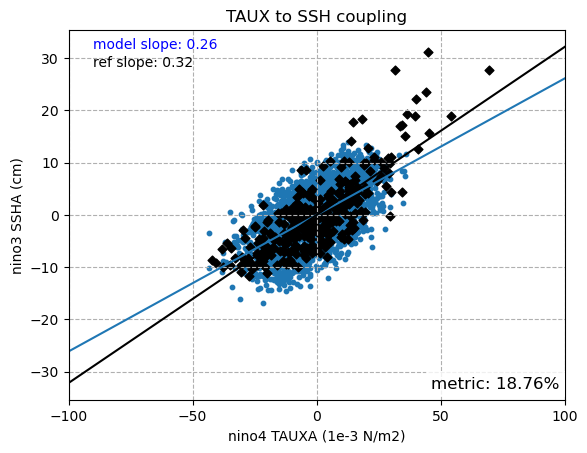

In [23]:
xseq = np.linspace(-100, 100, num=100)

slope, intcpt = linreg_1d(model_ssh_prep["ACCESS-ESM1-5"], model_tauu_prep["ACCESS-ESM1-5"])
plt.plot(xseq, intcpt+slope*xseq)
mod_slope = slope
print(slope)

slope, intcpt = linreg_1d(obs_zos_prep["CMEMS"].data, obs_tauu_prep["ERA-Interim"].data)
plt.plot(xseq, intcpt+slope*xseq, color='black')
metric_val = abs((mod_slope-slope)/slope)*100

print(model_tauu_prep["ACCESS-ESM1-5"].shape, model_ssh_prep["ACCESS-ESM1-5"].shape) #scatter plot
print(model_tauu_prep["ACCESS-ESM1-5"].units, model_ssh_prep["ACCESS-ESM1-5"].units) #ssh cm
plt.scatter(model_tauu_prep["ACCESS-ESM1-5"].data, model_ssh_prep["ACCESS-ESM1-5"].data, s=10)
yunit = model_ssh_prep["ACCESS-ESM1-5"].units 
xunit = model_tauu_prep["ACCESS-ESM1-5"].units

print(obs_zos_prep["CMEMS"].shape, obs_tauu_prep["ERA-Interim"].shape)
plt.scatter(obs_tauu_prep["ERA-Interim"].data, obs_zos_prep["CMEMS"].data, s=20, c='black', marker='D')
plt.xlim(-100,100)
plt.xticks(np.arange(-100,110,50))
plt.title('TAUX to SSH coupling')
plt.ylabel(f'nino3 SSHA ({yunit})')
plt.xlabel(f'nino4 TAUXA ({xunit})')
plt.grid(linestyle='--')
## text slope
plt.text(0.05,0.95, f'model slope: {mod_slope:.2f}', color='blue',transform=plt.gca().transAxes)
plt.text(0.05,0.9, f'ref slope: {slope:.2f}', color='black', transform=plt.gca().transAxes)

plt.text(0.99, 0.03, f'metric: {metric_val:.2f}%', fontsize=12, ha='right',
         transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
print(metric_val)

# Diagnostic Level 2

In [21]:
import pandas as pd

def linreg_df(var_a, var_b):
    B_data = np.array(var_b)
    B_with_intercept = np.vstack([B_data, np.ones_like(B_data)]).T
    coefs, _, _, _ = np.linalg.lstsq(B_with_intercept, np.array(var_a), rcond=None)
    slope, intercept = coefs[0], coefs[1]
    return slope, intercept

def plt_lvl2_subplot(y_cube, x_cube, dataset_label):
    
    df = pd.DataFrame({'var_a':y_cube.data, 'var_b':x_cube.data})
    slopes = []
    print(dataset_label, 'shape: ', df.shape)
    plt.scatter(x_cube.data, y_cube.data, c='k', s=10)
    xseq = np.linspace(-100, 100, num=50)
    slope, intcpt = linreg_df(df['var_a'], df['var_b'])
    plt.plot(xseq, intcpt+slope*xseq, c='black')
    slopes.append(slope)
    
    xseq = np.linspace(-100, 0, num=50) #
    slope, intcpt = linreg_df(df.loc[df['var_b']<0, 'var_a'], df.loc[df['var_b']<0, 'var_b'])
    
    plt.plot(xseq, intcpt+slope*xseq, linewidth=3)
    slopes.append(slope)
    
    xseq = np.linspace(0, 100, num=50)
    slope, intcpt = linreg_df(df.loc[df['var_b']>0, 'var_a'], df.loc[df['var_b']>0, 'var_b'])
    plt.plot(xseq, intcpt+slope*xseq, color='red', linewidth=3)
    slopes.append(slope)

    plt.title(dataset_label)
    plt_settings(slopes)

def plt_settings(slopes):
    plt.xlim(-100,100)
    plt.xticks(np.arange(-100,110,50))
    plt.ylim(-40,40)
    plt.yticks(np.arange(-40,50,20))
    plt.grid(linestyle='--')
    plt.ylabel(f'nino3 SSHA (cm)')
    plt.xlabel(f'nino4 TAUXA (1e-3 N/m2)')
    print(slopes)
    plt.text(0.02, 0.85, f'slope(all): {slopes[0]:.2f}\nslope(x<0): {slopes[1]:.2f}\nslope(x>0): {slopes[2]:.2f}', fontsize=12, ha='left',
         transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

ACCESS-ESM1-5 shape:  (1980, 2)
[0.26121965, 0.18604478, 0.2318598]
CMEMS_ERA-Interim shape:  (312, 2)
[0.32155845, 0.2193223, 0.46708634]


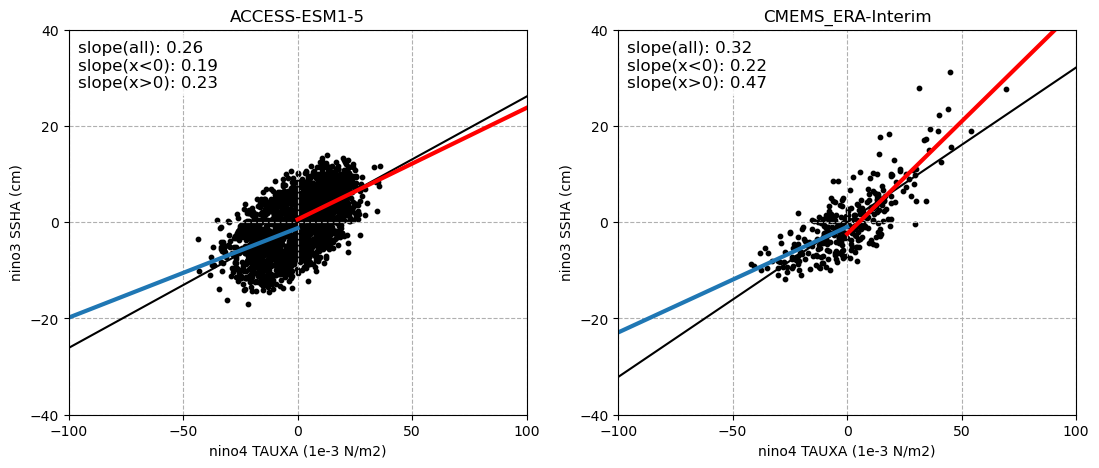

In [22]:
fig = plt.figure(figsize=(13, 5))
ax = plt.subplot(121)

plt_lvl2_subplot(model_ssh_prep["ACCESS-ESM1-5"], model_tauu_prep["ACCESS-ESM1-5"], 'ACCESS-ESM1-5')

ax = plt.subplot(122)
plt_lvl2_subplot(obs_zos_prep["CMEMS"], obs_tauu_prep["ERA-Interim"], 'CMEMS_ERA-Interim')

Figure 2: scatterplot of zonal wind stress anomalies (TauxA) in the western equatorial Pacific (Niño4 averaged) and sea surface height anomalies (SSHA) in the eastern equatorial Pacific (Niño3 averaged), showing the possible nonlinearity in the strength of the Taux-to-SSH coupling (usually shows weak nonlinearity, with a gentler slope for TauxA<0 and steeper slope for TauxA>0 in both reference and model). The black, red and blue lines and numbers show respectively linear regression computed for all TauxA, TauxA>0 and TauxA<0, the left and right scatterplots show respectively the reference and the model

## Dive down level 3
The third level shows the remote coupling in the equatorial Pacific.

In [24]:
#level 3 zonal runningaverage
from esmvalcore.preprocessor import meridional_statistics
from esmvalcore.preprocessor import mask_above_threshold, mask_below_threshold

def taua_nino4(cube):
    nino4_region = {"start_longitude": 160., "end_longitude": 210., "start_latitude": -5., "end_latitude": 5.}
    # cube = extract_time(cube, start_year=1979, end_year=2000, start_month=1, end_month=12, start_day=1, end_day=31)
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    # cube = convert_units(cube, units="degC")
    cube = mask_landsea(cube, mask_out="land") #irregular
    cube = anomalies(cube, period="full")
    cube = detrend(cube, dimension="time", method="linear")
    cube = extract_region(cube, **nino4_region)
    cube = area_statistics(cube,operator='mean')    
    return cube

def ssh_eqp(cube):
    region = {"start_longitude": 150., "end_longitude": 270., "start_latitude": -5., "end_latitude": 5.}
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = convert_units(cube, units="cm")
    cube = mask_landsea(cube, mask_out="land") 
    cube = anomalies(cube, period="full")
    cube = detrend(cube, dimension="time", method="linear") # Create NaN for some reasons
    cube = extract_region(cube, **region)
    cube = meridional_statistics(cube,operator='mean')
    cube = rolling_window_statistics(cube, coordinate='longitude',operator='mean',window_length=30)
    return cube 
#lin_regress

In [32]:
model_zos = {name: ssh_eqp(dataset) for name, dataset in model_ssh_datasets.items()}
model_tauu = {name: taua_nino4(dataset) for name, dataset in model_tauu.items()}

obs_zos = {name: ssh_eqp(dataset) for name, dataset in obs_zos_datasets.items()}
obs_tauu = {name: taua_nino4(dataset) for name, dataset in obs_tauu_datasets.items()}

/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.6/lib/python3.11/site-packages/iris/cube.py:4330: IrisUserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.6/lib/python3.11/site-packages/iris/cube.py:4881: IrisIgnoringBoundsWarning: The bounds of coordinate 'longitude' were ignored in the rolling window operation.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.6/lib/python3.11/site-packages/iris/coords.py:2171: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'month_number', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'month_number'. Ignoring bounds.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.6/lib/python3.11/site-packages/iris/coords.py:2171: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid oper

In [33]:
def lin_regress_matrix(cubeA, cubeBsst):
    
    A_data = cubeA.data.reshape(cubeA.shape[0], -1)  # Shape (time, spatial_points)
    if cubeA.shape[0] == cubeBsst.shape[0]:
        B_data = cubeBsst.data.flatten() # or all
    else:
        B_data = cubeBsst.data.compressed() # masked threshold cube (time,) 

    # Add intercept term by stacking a column of ones with cubeB
    B_with_intercept = np.vstack([B_data, np.ones_like(B_data)]).T
    
    print('least squares data shapes ',B_with_intercept.shape, A_data.shape)
    # Solve the linear equations using least squares method
    coefs, _, _, _ = np.linalg.lstsq(B_with_intercept, A_data, rcond=None)

    # Create a new Iris Cube for the regression results
    result_cube = iris.cube.Cube(coefs[0], long_name='regression SSTA,TAUXA',
                                 dim_coords_and_dims=[(cubeA.coord('longitude'), 0)])

    return result_cube


def feedback_nonlin(sst_cube, tauu_cube):
    tauu_aux = tauu_cube.copy()
    sst_coord = iris.coords.AuxCoord(sst_cube.data, sst_cube.standard_name, sst_cube.long_name, sst_cube.var_name, sst_cube.units)
    tauu_aux.add_aux_coord(sst_coord, 0)
    print(sst_cube.standard_name, sst_cube.long_name, sst_cube.var_name, sst_cube.units)

    below0 = iris.Constraint(surface_downward_eastward_stress=lambda cell: cell < 0) #change variable
    above0 = iris.Constraint(surface_downward_eastward_stress=lambda cell: cell > 0)
    ssta_neg = mask_above_threshold(sst_cube.copy(), 0) #x<0
    ssta_pos = mask_below_threshold(sst_cube.copy(), 0) #x>0
    xbelow0 = tauu_aux.extract(below0)
    xabove0 = tauu_aux.extract(above0)
    
    outreg_cube = lin_regress_matrix(xbelow0, ssta_neg)
    posreg_cube = lin_regress_matrix(xabove0, ssta_pos)

    return outreg_cube, posreg_cube

def format_longitude(x, pos):
    if x > 180:
        return f'{int(360 - x)}°W'
    elif x == 180:
        return f'{int(x)}°'
    else:
        return f'{int(x)}°E'
        

surface_downward_eastward_stress Surface Downward Eastward Wind Stress tauu Pa
least squares data shapes  (938, 2) (938, 91)
least squares data shapes  (1042, 2) (1042, 91)
surface_downward_eastward_stress Surface Downward Eastward Wind Stress tauu Pa
least squares data shapes  (164, 2) (164, 91)
least squares data shapes  (148, 2) (148, 91)
least squares data shapes  (1980, 2) (1980, 91)
least squares data shapes  (312, 2) (312, 91)


Text(0.5, 1.0, 'SSH-Wind feedback')

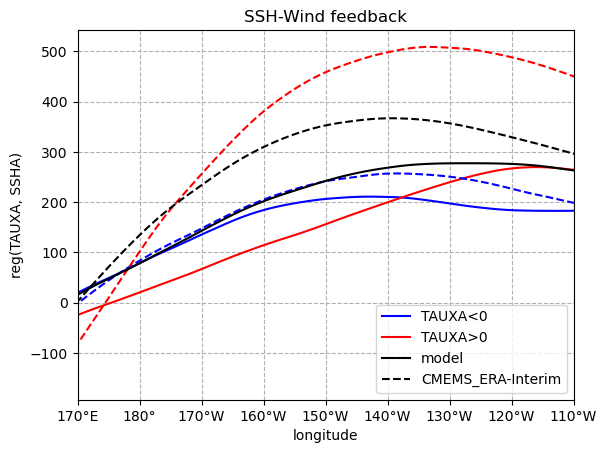

In [35]:

neg, pos = feedback_nonlin(model_tauu["ACCESS-ESM1-5"], model_zos["ACCESS-ESM1-5"])

qplt.plot(neg, color='blue', linestyle='solid', label='TAUXA<0')
qplt.plot(pos, color='red', linestyle='solid', label='TAUXA>0')

neg, pos = feedback_nonlin(obs_tauu["ERA-Interim"], obs_zos["CMEMS"])
qplt.plot(neg, color='blue', linestyle='--')
qplt.plot(pos, color='red', linestyle='--')

cb = lin_regress_matrix(model_zos["ACCESS-ESM1-5"], model_tauu["ACCESS-ESM1-5"])
        
qplt.plot(cb, color='black', linestyle='solid', label='model')

cb2 = lin_regress_matrix(obs_zos["CMEMS"], obs_tauu["ERA-Interim"])
qplt.plot(cb2, color='black', linestyle='--', label='CMEMS_ERA-Interim')

plt.xlim(170, 250)
plt.xlabel('longitude')
plt.ylabel('reg(TAUXA, SSHA)')
plt.grid(linestyle='--')
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_longitude))
plt.legend()
plt.title("SSH-Wind feedback")


Figure 3: spatial structure sea surface height anomalies (SSHA) in the equatorial Pacific (meridional 5°S-5°N average; zonal 30° running average) regessed onto zonal wind stress anomalies (TauxA) in the western equatorial Pacific (Niño4 averaged), showing the possible nonlinearity in the strength of the Taux-to-SSH coupling (the reference shows the maximum coupling around 140°W, same position or slightly westward for TauxA<0, around 120°W for TauxA>0, with a stronger amplitude for TauxA>0; usually the models simulate a very small displacement of the maximum coupling for all TauxA, TauxA<0, TauxA>0 and simulate similar amplitude in each case). The black, red and blue lines and numbers show respectively linear regression computed for all TauxA, TauxA>0 and TauxA<0, the dashed and solid curves show respectively the reference and the model.